<a href="https://colab.research.google.com/github/shylitboi/Personal-Project/blob/main/BBC_Text_Summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BBC 뉴스 기사 핵심 정보 요약 프로젝트
---
```
[데이터 수집 및 탐색]
     ↓
[전처리: 문장 분할, 정제, 벡터화]
     ↓
[요약 모델 개발]
    ├─ TF-IDF 기반 요약
    ├─ TextRank 기반 요약
    └─ 하이브리드 요약
     ↓
[성능 평가]
    ├─ 정량적: ROUGE, BERTScore, Meteor Score
    └─ 정성적: 오류 사례 분석
     ↓
[결과 분석 및 결론 도출]
```

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install wordcloud
import os
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download("punkt")
import warnings
warnings.filterwarnings("ignore")
nltk.download('punkt_tab')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.6/167.6 kB 6.3 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /Users/sonyunboi/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/sonyunboi/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

# 데이터 로드
---

In [ ]:
df = pd.read_csv("/Users/sonyunboi/Desktop/Cau/25-1/텍딥/개인프로젝트/dF.csv")
df.head()

,filename,category,article_path,summary_path,article_text,summary_text,article_sent_count,summary_sent_count,article_word_count,summary_word_count
0,078.txt,sport,/content/drive/MyDrive/Colab Notebooks/CAU/텍...,/content/drive/MyDrive/Colab Notebooks/CAU/텍...,Butler strikes gold in Spain\n\nBritain's Kath...,Gelete Burka then crowned a great day for Ethi...,8,1,191,92
1,148.txt,sport,/content/drive/MyDrive/Colab Notebooks/CAU/텍...,/content/drive/MyDrive/Colab Notebooks/CAU/텍...,Palace threat over Cantona masks\n\nManchester...,Manchester United fans wearing Eric Cantona ma...,7,3,177,58
2,370.txt,sport,/content/drive/MyDrive/Colab Notebooks/CAU/텍...,/content/drive/MyDrive/Colab Notebooks/CAU/텍...,Robinson wants dual code success\n\nEngland ru...,"Robinson, a former rugby league international ...",17,4,373,144
3,381.txt,sport,/content/drive/MyDrive/Colab Notebooks/CAU/텍...,/content/drive/MyDrive/Colab Notebooks/CAU/텍...,England claim Dubai Sevens glory\n\nEngland be...,England beat Fiji 26-21 in a dramatic final in...,10,1,261,80
4,475.txt,sport,/content/drive/MyDrive/Colab Notebooks/CAU/텍...,/content/drive/MyDrive/Colab Notebooks/CAU/텍...,Agassi fear for Melbourne\n\nAndre Agassi's in...,"""I was not counting on this being the end of t...",12,3,274,90


# EDA
---

## 1. 카테고리별 뉴스 기사 개수 시각화
- 각 카테고리(`politics`, `business`, `tech`, ...)에 포함된 기사 수를 파악하여 데이터셋의 균형 여부를 확인한다.
- 특정 카테고리 중심의 실험 진행 여부를 판단하는 데 도움을 준다.

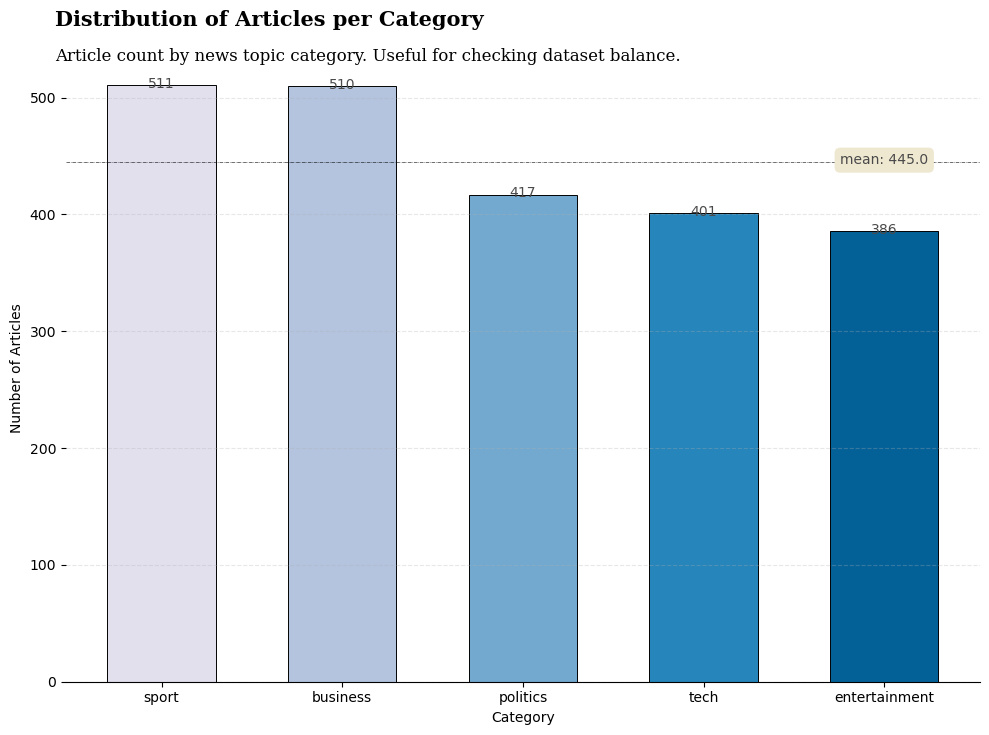

In [ ]:
# 카테고리별 기사 수
category_counts = df["category"].value_counts()
mean_count = category_counts.mean()

# 색상 팔레트 지정
palette = sns.color_palette("PuBu", len(category_counts))
colors = [palette[i] for i in range(len(category_counts))]

# 시각화
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

ax.bar(category_counts.index, category_counts.values,
       color=colors, width=0.6,
       edgecolor='black', linewidth=0.7)

# 평균선
ax.axhline(mean_count, color='black', linewidth=0.4, linestyle='dashdot')
ax.annotate(f"mean: {mean_count:.1f}",
            xy=(category_counts.index[-1], mean_count + 1.5),
            ha='center', va='center',
            color='#4a4a4a',
            bbox=dict(boxstyle='round', pad=0.4, facecolor='#efe8d1', linewidth=0))

# 값 주석
for i, val in enumerate(category_counts.values):
    ax.annotate(f"{val}",
                xy=(category_counts.index[i], val + 1),
                ha='center', va='center',
                fontweight='light', color='#4a4a4a')

# 스타일 조정
for spine in ["top", "right", "left"]:
    ax.spines[spine].set_visible(False)

ax.set_ylabel("Number of Articles")
ax.set_xlabel("Category")
ax.grid(axis='y', linestyle='--', alpha=0.3)

# 제목 및 부제목
fig.text(0.06, 1.02, "Distribution of Articles per Category", fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.06, 0.97, "Article count by news topic category. Useful for checking dataset balance.", fontsize=12, fontweight='light', fontfamily='serif')

plt.tight_layout()
plt.show()



## 2. 뉴스 원문 및 요약문의 문장 수 분포 확인
- 기사와 요약 문장 수의 분포를 비교하여, 요약문의 길이를 설정할 기준을 마련한다.
- 예: 평균적으로 요약이 3~5문장이라면, 모델 출력도 top-5 문장으로 제한 가능


In [ ]:
# 평균 문장 수 계산
article_mean = df["article_sent_count"].mean()
summary_mean = df["summary_sent_count"].mean()

print(f"뉴스 본문 평균 문장 수: {df['article_sent_count'].mean():.2f}")
print(f"요약 평균 문장 수: {df['summary_sent_count'].mean():.2f}")

뉴스 본문 평균 문장 수: 18.62
요약 평균 문장 수: 2.08


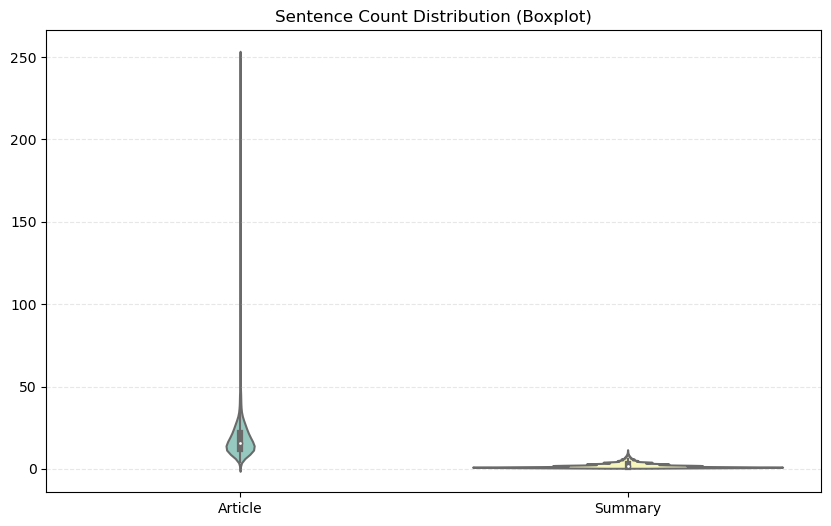

In [ ]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=df[["article_sent_count", "summary_sent_count"]], palette="Set3")
plt.xticks([0, 1], ["Article", "Summary"])
plt.title("Sentence Count Distribution (Boxplot)")
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

## 3. 단어 수 기반 길이 분포 추가 분석
- 문장 수 외에도 실제 단어 수 기준으로도 분포를 확인하여, 모델 입력/출력 시퀀스 길이 제한을 설정하는 데 활용한다.


In [ ]:
article_word_avg = df["article_word_count"].mean()
summary_word_avg = df["summary_word_count"].mean()

print(f"뉴스 본문 평균 단어 수: {article_word_avg:.2f}")
print(f"요약문 평균 단어 수: {summary_word_avg:.2f}")

뉴스 본문 평균 단어 수: 438.30
요약문 평균 단어 수: 184.01


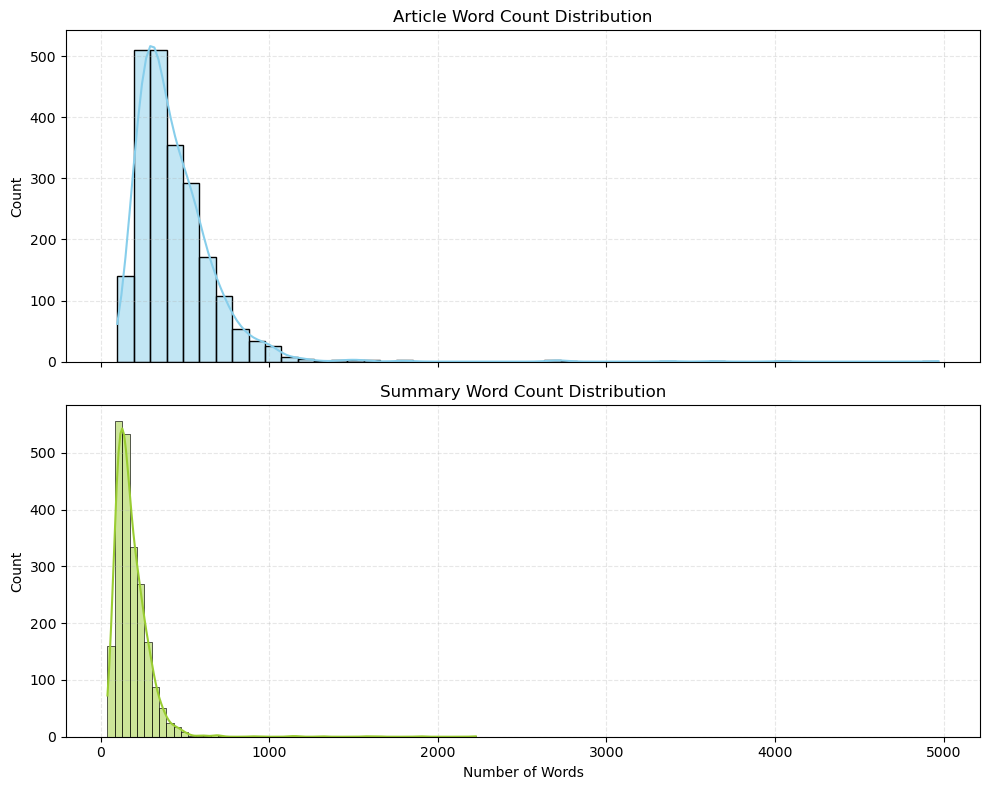

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# 뉴스 본문 단어 수 분포
sns.histplot(df["article_word_count"], kde=True, color="skyblue", bins=50, ax=axs[0])
axs[0].set_title("Article Word Count Distribution")
axs[0].grid(True, linestyle='--', alpha=0.3)

# 요약문 단어 수 분포
sns.histplot(df["summary_word_count"], kde=True, color="yellowgreen", bins=50, ax=axs[1])
axs[1].set_title("Summary Word Count Distribution")
axs[1].grid(True, linestyle='--', alpha=0.3)

plt.xlabel("Number of Words")
plt.tight_layout()
plt.show()

## 4. 본문 길이에 따른 요약 길이 상관관계 분석
- 긴 뉴스일수록 요약이 길어지는 경향이 있는지 확인
- 상관계수가 높을 경우, 모델의 길이 제어를 기사 길이에 따라 조절할 수 있음


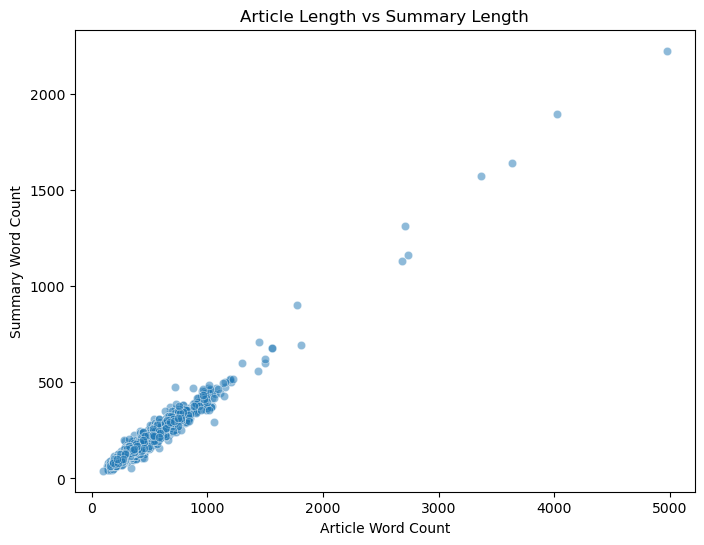


상관계수: 0.98


In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(x="article_word_count", y="summary_word_count", data=df, alpha=0.5)
plt.title("Article Length vs Summary Length")
plt.xlabel("Article Word Count")
plt.ylabel("Summary Word Count")
plt.show()

# 상관계수 출력
correlation = df["article_word_count"].corr(df["summary_word_count"])
print()
print(f"상관계수: {correlation:.2f}")

**본문이 길면 요약문도 길다**

## 5. 카테고리별 요약 길이, 문장 수분석
- 뉴스 종류에 따라 요약 길이의 특징이 달라지는지 확인
- 카테고리별로 서로 다른 요약 전략을 설계할 수 있는 근거 제공


In [ ]:
summary_stats = df.groupby("category")["summary_word_count"].agg(["mean", "median", "std", "min", "max"]).round(2)
display(summary_stats)

,mean,median,std,min,max
category,,,,,
business,156.47,142.0,66.56,44,469
entertainment,161.54,133.0,139.09,63,1897
politics,216.40,204.0,150.58,40,2225
sport,162.98,139.0,90.12,44,692
tech,233.78,207.0,124.69,69,1575


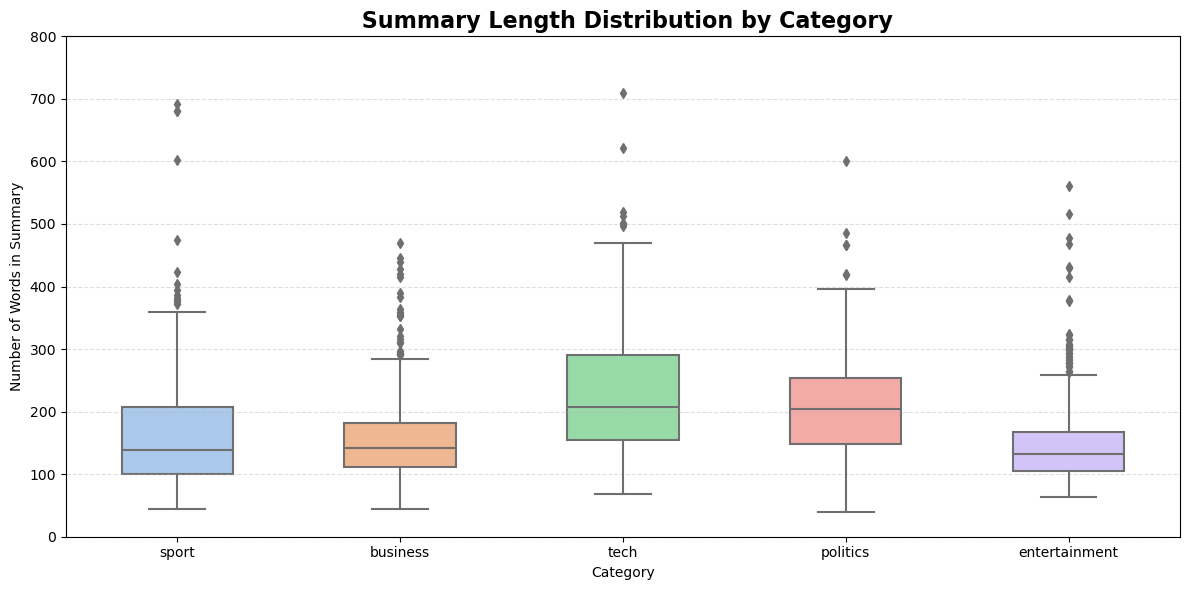

In [ ]:
plt.figure(figsize=(12, 6))

sns.boxplot(
    x="category",
    y="summary_word_count",
    data=df,
    palette="pastel",
    width=0.5,
)

# 타이틀, 축 레이블
plt.title(" Summary Length Distribution by Category", fontsize=16, fontweight='bold')
plt.ylabel("Number of Words in Summary")
plt.xlabel("Category")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.ylim(0, 800)  # 시각적으로 보기 좋게 잘라줌
plt.tight_layout()
plt.show()

In [ ]:
# 카테고리별 요약 문장 수 평균 계산
category_summary_stats = df.groupby("category")["summary_sent_count"].agg(["count", "mean", "std"]).reset_index()
category_summary_stats.columns = ["category", "num_articles", "avg_summary_sent", "std_dev"]

# 결과 확인
print(category_summary_stats)

        category  num_articles  avg_summary_sent   std_dev
0       business           510          1.580392  0.944640
1  entertainment           386          1.751295  1.419827
2       politics           417          2.124700  1.309649
3          sport           511          2.696673  1.764566
4           tech           401          2.199501  1.593769


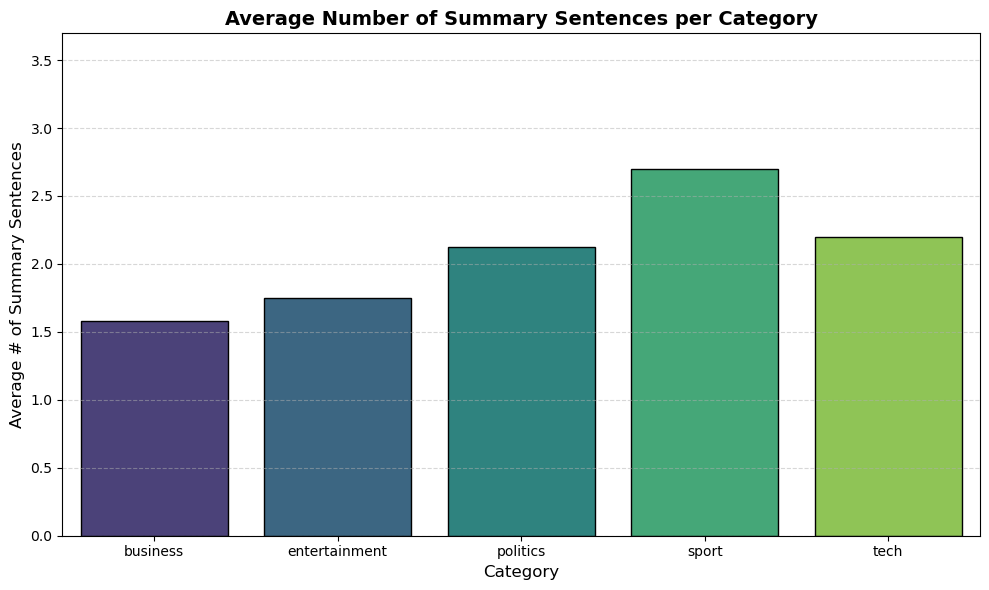

In [ ]:
# 시각화 (평균 요약 문장 수)
plt.figure(figsize=(10, 6))
sns.barplot(
    data=category_summary_stats,
    x="category",
    y="avg_summary_sent",
    palette="viridis",
    edgecolor="black"
)

plt.title("Average Number of Summary Sentences per Category", fontsize=14, fontweight="bold")
plt.xlabel("Category", fontsize=12)
plt.ylabel("Average # of Summary Sentences", fontsize=12)
plt.ylim(0, category_summary_stats["avg_summary_sent"].max() + 1)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

## 6. 카테고리별 TF-IDF 기반 핵심 단어 시각화 (WordCloud)
- 전체 뉴스 기사에서 등장하는 중요 단어를 TF-IDF 기준으로 시각화
- 모델이 어떤 키워드 중심으로 요약될 수 있는지 직관적으로 파악 가능
- Nltk 불용어 리스트 임포트해서 없앰

In [ ]:
from tkinter import font
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

# NLTK 영어 불용어 다운로드
nltk.download("stopwords")
nltk_stopwords = stopwords.words("english")

# 카테고리별 WordCloud 함수
def show_wordcloud_for_category(category_name):
    # 해당 카테고리의 모든 뉴스 기사 텍스트 결합
    text = " ".join(df[df["category"] == category_name]["article_text"])

    # TF-IDF 벡터라이저
    vectorizer = TfidfVectorizer(
        stop_words=nltk_stopwords,
        max_features=100,
        token_pattern=r'\b[a-zA-Z]{4,}\b'  # 4글자 이상 단어만 허용
    )

    X = vectorizer.fit_transform([text])
    words = vectorizer.get_feature_names_out()
    scores = X.toarray()[0]

    tfidf_scores = {word: score for word, score in zip(words, scores)}

    # WordCloud 생성 및 시각화
    wordcloud = WordCloud(width=1000, height=500, background_color="white",
                          colormap="PuBu", max_words=100).generate_from_frequencies(tfidf_scores)

    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"TF-IDF WordCloud - {category_name.title()}", fontsize=16,fontweight='bold')
    plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sonyunboi/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


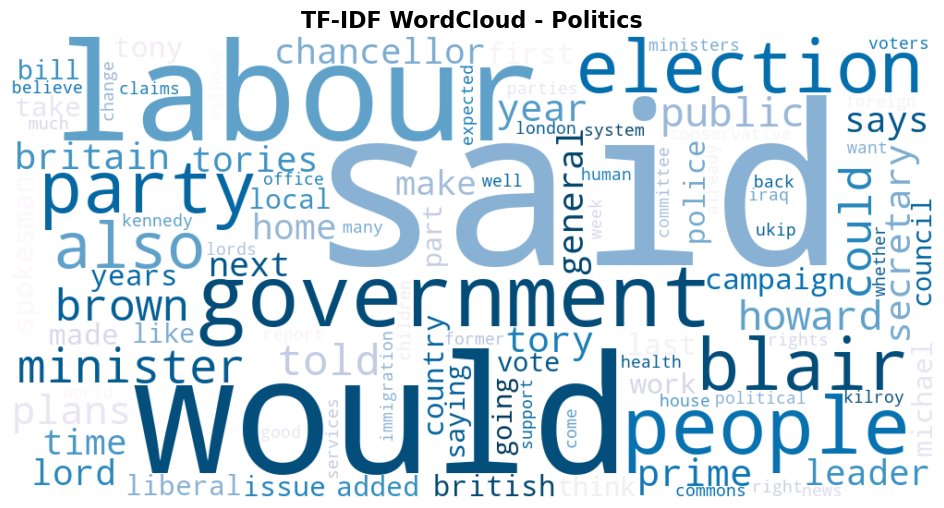

In [ ]:
show_wordcloud_for_category("politics")

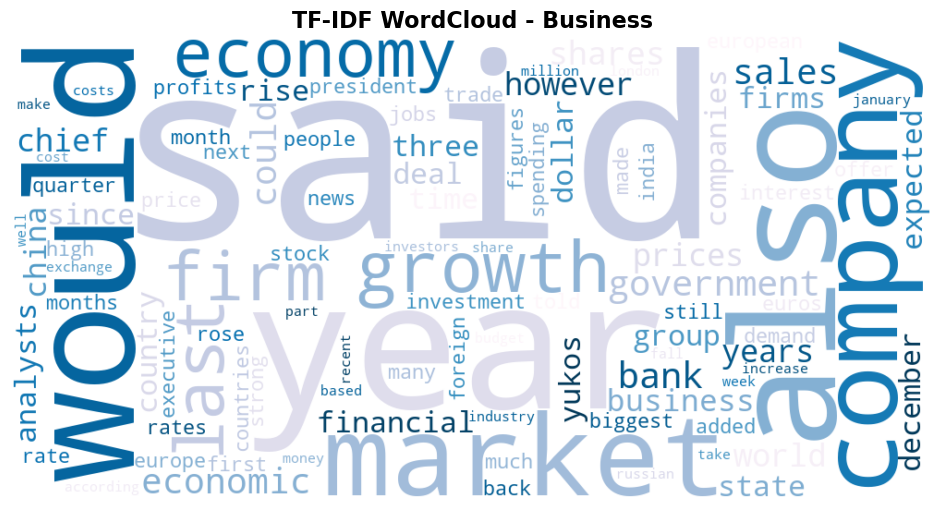

In [ ]:
show_wordcloud_for_category("business")

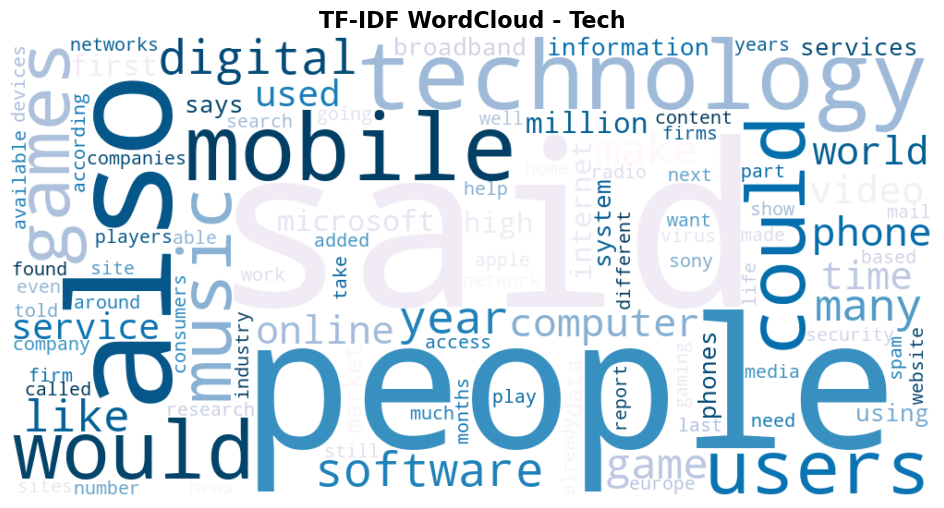

In [ ]:
show_wordcloud_for_category("tech")

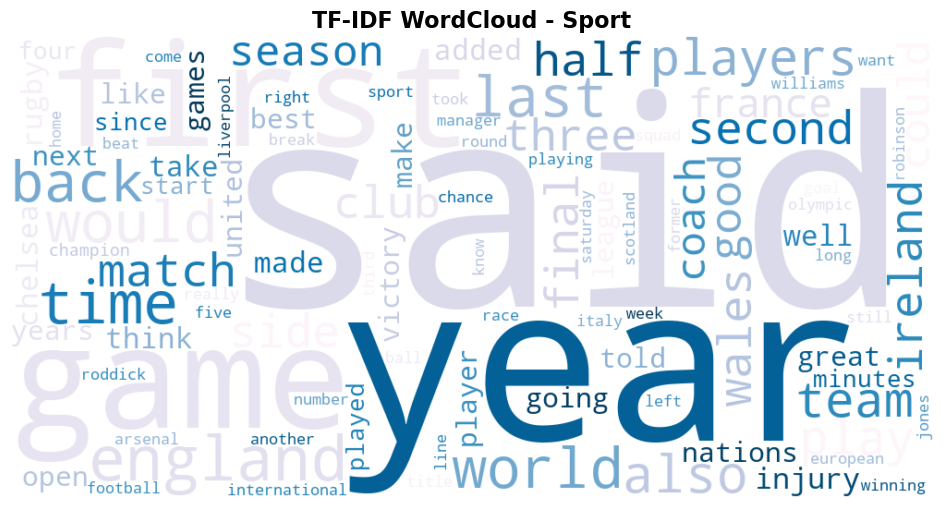

In [ ]:
show_wordcloud_for_category("sport")

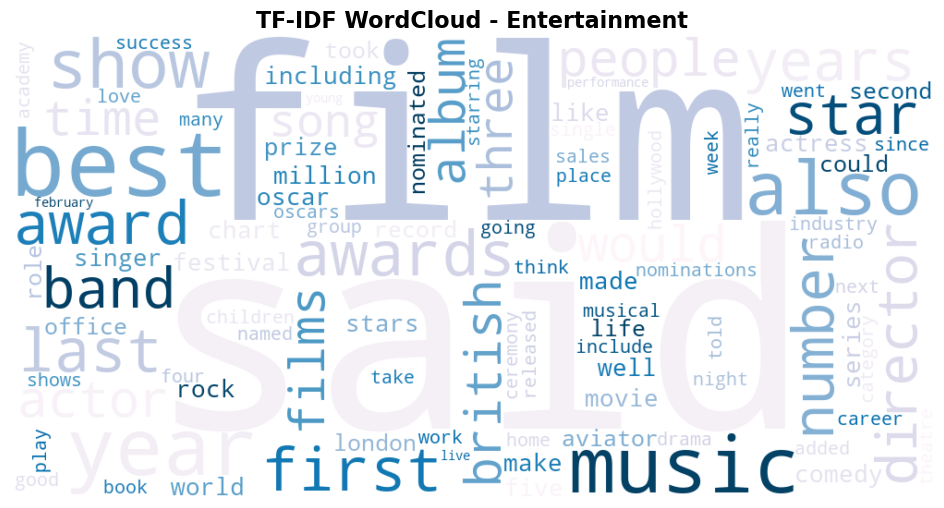

In [ ]:
show_wordcloud_for_category("entertainment")

## EDA 인사이트
---
```
1. 뉴스 기사 및 요약 길이 분포
- 뉴스 본문 평균 문장 수: 18.62  
- 요약 평균 문장 수: 2.08  
- 뉴스 본문 평균 단어 수: 438.30  
- 요약 평균 단어 수: 184.01  
```

```
2. 본문-요약 길이 상관관계
- 문장 수 기준 상관계수 = 0.98 (매우 강한 양의 상관관계)
```
  ➡️ 본문 길이에 비례해 요약 길이 조절 (Adaptive Summary Length) 전략 활용 가능


```
3. 카테고리별 기사 수 분포
- 카테고리 간 기사 수 편차는 크지 않음 (최소 386 ~ 최대 511)  
```
  ➡️ 클래스 불균형 이슈는 거의 없음


```
4. 카테고리별 요약 길이 편차
- tech / politics: 요약이 가장 길고 정보량 많음  
- sport / entertainment: 짧고 간결한 요약 선호  
```
  ➡️ 카테고리별 요약 길이 전략 차등 적용 고려 (ex. tech: top-5, sport: top-2)



# 전처리
---


1. **문자 정제 (clean_text)**  
   - 텍스트를 소문자로 변환하여 대소문자 차이에 따른 불일치를 제거  
   - 정규표현식을 사용해 알파벳, 숫자, 공백만 남기고 특수문자와 불필요한 공백을 제거

2. **불용어 제거 (remove_stopwords)**  
   - `nltk.word_tokenize`를 이용해 텍스트를 단어 단위로 분리  
   - NLTK 불용어 목록에 포함된 단어들을 제거하여 핵심 단어 중심의 텍스트로 변환

3. **전체 파이프라인 (preprocess_text)**  
   - 위 두 과정을 순차적으로 적용하여 정제된 텍스트를 생성

4. **문장 토큰화 (tokenize_sentences)**  
   - 원문을 `sent_tokenize` 함수를 사용해 문장 단위로 분리  
   - 이렇게 생성된 문장 리스트는 추출적 요약 모델에서 후보 문장을 선택할 때, 또는 문장 길이 분석에 활용

5. **데이터프레임에 전처리 결과 추가**  
   - 원본 텍스트(`article_text`, `summary_text`)에 대해 전처리한 결과를 각각 `article_clean`, `summary_clean` 컬럼에 저장  
   - 원본 문장 리스트도 `article_sents` 컬럼에 저장하여 원문의 구조적 정보를 보존



In [ ]:
import re

# 불용어 목록
stop_words = set(stopwords.words("english"))

# 문장 토큰화
def tokenize_sentences(text):
    return sent_tokenize(text)

# 특수문자 제거 + 소문자화
def clean_text(text):
    text = text.lower() # 소문자화
    text = re.sub(r"[^a-z0-9\s]", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

# 불용어 제거
def remove_stopwords(text):
    tokens = word_tokenize(text)
    filtered = [word for word in tokens if word not in stop_words]
    return " ".join(filtered)

# 전체 전처리 파이프라인
def preprocess_text(text):
    cleaned = clean_text(text)
    no_stop = remove_stopwords(cleaned)
    return no_stop

# 본문 및 요약 전처리 컬럼 추가
df["article_clean"] = df["article_text"].apply(preprocess_text)
df["summary_clean"] = df["summary_text"].apply(preprocess_text)

# 문장 토큰화 (요약 길이 설정 등에 사용)
df["article_sents"] = df["article_text"].apply(tokenize_sentences)

# 각 문장을 전처리한 리스트로 변환
df["article_sents_cleaned"] = df["article_sents"].apply(
    lambda sents: [preprocess_text(s) for s in sents]
)

In [ ]:
df.drop(columns=["article_path", "summary_path"], inplace=True)

**Top-N 기준**
```
평균 + 표준편차/2 < 2.5 → Top-2

평균 + 표준편차/2 ≥ 2.5 and < 3.5 → Top-3

평균 + 표준편차/2 ≥ 3.5 → Top-4
```

In [ ]:
def decide_topn(row):
    upper_bound = row["avg_summary_sent"] + row["std_dev"]/2
    if upper_bound < 2.5:
        return 2
    elif upper_bound < 3.5:
        return 3
    else:
        return 4

# 카테고리별 Top-N 설정
category_summary_stats["top_n"] = category_summary_stats.apply(decide_topn, axis=1)

# 딕셔너리 형태로 변환
category_to_topn = dict(zip(category_summary_stats["category"], category_summary_stats["top_n"]))
category_to_topn

{'business': 2, 'entertainment': 2, 'politics': 3, 'sport': 4, 'tech': 3}

In [ ]:
df.head()

,filename,category,article_text,summary_text,article_sent_count,summary_sent_count,article_word_count,summary_word_count,article_clean,summary_clean,article_sents,article_sents_cleaned
0,078.txt,sport,Butler strikes gold in Spain\n\nBritain's Kath...,Gelete Burka then crowned a great day for Ethi...,8,1,191,92,butler strikes gold spain britains kathy butle...,gelete burka crowned great day ethiopia claimi...,[Butler strikes gold in Spain\n\nBritain's Kat...,[butler strikes gold spain britains kathy butl...
1,148.txt,sport,Palace threat over Cantona masks\n\nManchester...,Manchester United fans wearing Eric Cantona ma...,7,3,177,58,palace threat cantona masks manchester united ...,manchester united fans wearing eric cantona ma...,[Palace threat over Cantona masks\n\nMancheste...,[palace threat cantona masks manchester united...
2,370.txt,sport,Robinson wants dual code success\n\nEngland ru...,"Robinson, a former rugby league international ...",17,4,373,144,robinson wants dual code success england rugby...,robinson former rugby league international swi...,[Robinson wants dual code success\n\nEngland r...,[robinson wants dual code success england rugb...
3,381.txt,sport,England claim Dubai Sevens glory\n\nEngland be...,England beat Fiji 26-21 in a dramatic final in...,10,1,261,80,england claim dubai sevens glory england beat ...,england beat fiji 2621 dramatic final dubai wi...,[England claim Dubai Sevens glory\n\nEngland b...,[england claim dubai sevens glory england beat...
4,475.txt,sport,Agassi fear for Melbourne\n\nAndre Agassi's in...,"""I was not counting on this being the end of t...",12,3,274,90,agassi fear melbourne andre agassis involvemen...,counting end day meandre agassis involvement a...,[Agassi fear for Melbourne\n\nAndre Agassi's i...,[agassi fear melbourne andre agassis involveme...


In [ ]:
df['article_sents'][0]

["Butler strikes gold in Spain\n\nBritain's Kathy Butler continued her impressive year with victory in Sunday's 25th Cross Internacional de Venta de Banos in Spain.",
 'The Scot, who led GB to World Cross Country bronze earlier this year, moved away from the field with Ines Monteiro halfway into the 6.6km race.',
 'She then shrugged off her Portuguese rival to win in 20 minutes 38 seconds.',
 "Meanwhile, Briton Karl Keska battled bravely to finish seventh in the men's 10.6km race in a time of 31:41.",
 'Kenenisa Bekele of Ethiopia - the reigning world long and short course champion - was never troubled by any of the opposition, winning leisurely in 30.26.',
 'Butler said of her success: "I felt great throughout the race and hope this is a good beginning for a marvellous 2005 season for me."',
 'Elsewhere, Abebe Dinkessa of Ethiopia won the Brussels IAAF cross-country race on Sunday, completing the 10,500m course in 33.22.',
 "Gelete Burka then crowned a great day for Ethiopia by claimi

In [ ]:
df['article_sents_cleaned'][0]

['butler strikes gold spain britains kathy butler continued impressive year victory sundays 25th cross internacional de venta de banos spain',
 'scot led gb world cross country bronze earlier year moved away field ines monteiro halfway 66km race',
 'shrugged portuguese rival win 20 minutes 38 seconds',
 'meanwhile briton karl keska battled bravely finish seventh mens 106km race time 3141',
 'kenenisa bekele ethiopia reigning world long short course champion never troubled opposition winning leisurely 3026',
 'butler said success felt great throughout race hope good beginning marvellous 2005 season',
 'elsewhere abebe dinkessa ethiopia brussels iaaf crosscountry race sunday completing 10500m course 3322',
 'gelete burka crowned great day ethiopia claiming victory womens race']

# 모델링

 ## TF-IDF 기반 문장 중요도
 ---
 각 문장별 TF-IDF 총합 → Top-N 문장 선택

 단순히 카테고리별 요약본의 평균 문장수를 반올림하면 편차를 반영하지 못하므로, 이를 반영하여 Top-N 설정

 **정제된 문장(article_sents_cleaned)으로 점수 계산, 원본 문장으로 출력**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

def summarize_with_cleaned_input(sentences, cleaned_sentences, top_n):
    if len(sentences) == 0:
        return ""
    elif len(sentences) <= top_n:
        return " ".join(sentences)

    # TF-IDF 계산 (정제된 문장 사용)
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(cleaned_sentences)

    # 중요도 계산
    sentence_scores = tfidf_matrix.sum(axis=1).flatten().tolist()[0]
    top_indices = np.argsort(sentence_scores)[-top_n:][::-1]
    top_indices_sorted = sorted(top_indices)

    # 최종 출력은 원문 문장
    return " ".join([sentences[i] for i in top_indices_sorted])

In [ ]:
df["tfidf_summary"] = df.apply(
    lambda row: summarize_with_cleaned_input(
        row["article_sents"],
        row["article_sents_cleaned"],
        category_to_topn[row["category"]]
    ),
    axis=1
)

In [ ]:
tf_idf_summary = df[[
    "filename", "category", "article_text", "summary_text", "tfidf_summary"
]].copy()

In [ ]:
tf_idf_summary.head()

,filename,category,article_text,summary_text,tfidf_summary
0,078.txt,sport,Butler strikes gold in Spain\n\nBritain's Kath...,Gelete Burka then crowned a great day for Ethi...,Butler strikes gold in Spain\n\nBritain's Kath...
1,148.txt,sport,Palace threat over Cantona masks\n\nManchester...,Manchester United fans wearing Eric Cantona ma...,United fans are planning to mark the 10th anni...
2,370.txt,sport,Robinson wants dual code success\n\nEngland ru...,"Robinson, a former rugby league international ...","Robinson, a former rugby league international ..."
3,381.txt,sport,England claim Dubai Sevens glory\n\nEngland be...,England beat Fiji 26-21 in a dramatic final in...,England claim Dubai Sevens glory\n\nEngland be...
4,475.txt,sport,Agassi fear for Melbourne\n\nAndre Agassi's in...,"""I was not counting on this being the end of t...",Agassi fear for Melbourne\n\nAndre Agassi's in...


## TextRank (Graph 기반)
---
**TextRank 요약 구조 요약** : 정제된 문장 → 벡터화(fast text) → 유사도(코사인) → 그래프 → PageRank → Top-N 인덱스 → 원문 출력

| 단계 | 설명 |
|------|------|
| 1️⃣ 문장 리스트 | `article_sents` → 원문 문장 리스트 |
| 2️⃣ 문장 정제 | `article_sents_cleaned` → 유사도 계산용 |
| 3️⃣ 문장 간 유사도 행렬 | Cosine Similarity 기반 |
| 4️⃣ 그래프 구성 | 노드 = 문장, 엣지 = 유사도 |
| 5️⃣ PageRank 적용 | 중요 문장 추출 |
| 6️⃣ 원문 기준 Top-N 문장 출력 | → 요약 생성 |

---


In [ ]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 3.7 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp311-cp311-macosx_15_0_arm64.whl size=283746 sha256=c786c4019d688cfc49589272054e2522ff5ce9e7a8a624ee4a73853bd8516fb0
  Stored in directory: /Users/sonyunboi/Library/Caches/pip/wheels/65/4f/35/5057db0249224e9ab55a513fa6b79451473ceb7713017823c3
Successfully built fasttext


In [ ]:
# FastText 모델 다운로드 및 로드
import fasttext.util
fasttext.util.download_model('en', if_exists='ignore')
ft = fasttext.load_model('cc.en.300.bin')
import networkx as nx
from tqdm import tqdm
tqdm.pandas()
# 코사인 유사도
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# 문장 벡터화 함수
def get_sentence_vector(sentence, model):
    words = word_tokenize(sentence)
    word_vecs = [model[word] for word in words if word in model]
    if len(word_vecs) == 0:
        return np.zeros(model.get_dimension())
    return np.mean(word_vecs, axis=0)

# text rank 기반 요약 함수
def summarize_textrank(sentences, cleaned_sentences, top_n):
    if len(sentences) == 0:
        return ""
    elif len(sentences) <= top_n:
        return " ".join(sentences)

    # 문장 벡터 생성
    sentence_vectors = [get_sentence_vector(sent, ft) for sent in cleaned_sentences]

    # 유사도 행렬 계산
    sim_matrix = cosine_similarity(sentence_vectors)

    # 그래프 생성 및 PageRank 수행
    nx_graph = nx.from_numpy_array(sim_matrix)
    scores = nx.pagerank(nx_graph)

    # 중요도 상위 문장 추출
    ranked = sorted(((scores[i], i) for i in range(len(scores))), reverse=True)
    top_indices = sorted([i for (_, i) in ranked[:top_n]])

    # 원문 기준 정렬 후 연결
    return " ".join([sentences[i] for i in top_indices])

In [ ]:
# 요약문 생성
df["textrank_summary"] = df.progress_apply(
    lambda row: summarize_textrank(
        row["article_sents"],
        row["article_sents_cleaned"],
        category_to_topn[row["category"]]
    ),
    axis=1
)

text_rank_summary = df[[
    "filename", "category", "article_text", "summary_text", "textrank_summary"
]].copy()

100%|███████████████████████████████████████| 2225/2225 [05:17<00:00,  7.02it/s]


In [ ]:
text_rank_summary.head()

,filename,category,article_text,summary_text,textrank_summary
0,078.txt,sport,Butler strikes gold in Spain\n\nBritain's Kath...,Gelete Burka then crowned a great day for Ethi...,"Meanwhile, Briton Karl Keska battled bravely t..."
1,148.txt,sport,Palace threat over Cantona masks\n\nManchester...,Manchester United fans wearing Eric Cantona ma...,Palace threat over Cantona masks\n\nManchester...
2,370.txt,sport,Robinson wants dual code success\n\nEngland ru...,"Robinson, a former rugby league international ...","""Beating the Aussies in both games would be a ..."
3,381.txt,sport,England claim Dubai Sevens glory\n\nEngland be...,England beat Fiji 26-21 in a dramatic final in...,England claim Dubai Sevens glory\n\nEngland be...
4,475.txt,sport,Agassi fear for Melbourne\n\nAndre Agassi's in...,"""I was not counting on this being the end of t...",Agassi fear for Melbourne\n\nAndre Agassi's in...


## 하이브리드 모델
---
* TF-IDF 가중치를 TextRank 초기값에 반영한 모델
* 중요 문장을 더 정교하게 반영 가능

```
[입력 텍스트 (뉴스 기사)]
        ↓
[문장 단위로 분할 + 전처리]
        ↓
[1. FastText: 문장 임베딩]
        ↓
[2. Cosine Similarity → 문장 간 유사도 행렬]
        ↓
[3. TF-IDF: 각 문장에 대한 단어 중요도 스코어 계산]
        ↓
[4. 그래프 생성 (유사도 행렬 기반)]
        ↓
[5. PageRank 수행: TF-IDF 스코어를 초기 가중치(personalization)로 사용]
        ↓
[6. 최종 문장 중요도 상위 Top-N 문장 선택 → 요약]
```

In [ ]:
def summarize_hybrid_textrank(sentences, cleaned_sentences, top_n):
    if len(sentences) == 0:
        return ""
    elif len(sentences) <= top_n:
        return " ".join(sentences)

    # ▶ 문장 벡터 (FastText 기반)
    sentence_vectors = [get_sentence_vector(sent, ft) for sent in cleaned_sentences]

    # ▶ 문장 간 유사도 행렬 (코사인 유사도)
    sim_matrix_hybrid = cosine_similarity(sentence_vectors)  # 변수명 변경

    # ▶ TF-IDF 기반 문장 스코어 계산 (정제된 문장 사용)
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(cleaned_sentences)

    # tfidf_scores를 완전히 flatten 하여 숫자 리스트로 만듦
    tfidf_scores = np.array(tfidf_matrix.sum(axis=1)).flatten().tolist()

    # ▶ 정규화 (sum = 1로 맞춰서 PageRank에 넣기 위함)
    total = sum(tfidf_scores)
    if total == 0:
        tfidf_scores = [1 / len(sentences)] * len(sentences)
    else:
        tfidf_scores = [s / total for s in tfidf_scores]

    # ▶ TextRank 그래프 생성
    nx_graph = nx.from_numpy_array(sim_matrix_hybrid)  # 수정된 변수 사용

    # ▶ PageRank + TF-IDF 기반 초기 가중치 (personalization)
    personalization = {i: tfidf_scores[i] for i in range(len(sentences))}
    scores = nx.pagerank(nx_graph, personalization=personalization)

    # ▶ 상위 중요 문장 Top-N 선택
    ranked = sorted(((scores[i], i) for i in range(len(scores))), reverse=True)
    top_indices = sorted([i for (_, i) in ranked[:top_n]])

    return " ".join([sentences[i] for i in top_indices])

In [ ]:
df["hybrid_summary"] = df.progress_apply(
    lambda row: summarize_hybrid_textrank(
        row["article_sents"],
        row["article_sents_cleaned"],
        category_to_topn[row["category"]]
    ),
    axis=1
)

100%|███████████████████████████████████████| 2225/2225 [04:55<00:00,  7.53it/s]


In [ ]:
hybrid_summary = df[[
    "filename", "category", "article_text", "summary_text", "hybrid_summary"
]].copy()

hybrid_summary.head()

,filename,category,article_text,summary_text,hybrid_summary
0,078.txt,sport,Butler strikes gold in Spain\n\nBritain's Kath...,Gelete Burka then crowned a great day for Ethi...,"The Scot, who led GB to World Cross Country br..."
1,148.txt,sport,Palace threat over Cantona masks\n\nManchester...,Manchester United fans wearing Eric Cantona ma...,Palace threat over Cantona masks\n\nManchester...
2,370.txt,sport,Robinson wants dual code success\n\nEngland ru...,"Robinson, a former rugby league international ...","""Beating the Aussies in both games would be a ..."
3,381.txt,sport,England claim Dubai Sevens glory\n\nEngland be...,England beat Fiji 26-21 in a dramatic final in...,England claim Dubai Sevens glory\n\nEngland be...
4,475.txt,sport,Agassi fear for Melbourne\n\nAndre Agassi's in...,"""I was not counting on this being the end of t...",Agassi fear for Melbourne\n\nAndre Agassi's in...


In [ ]:
hybrid_summary['hybrid_summary'][0]

"The Scot, who led GB to World Cross Country bronze earlier this year, moved away from the field with Ines Monteiro halfway into the 6.6km race. Meanwhile, Briton Karl Keska battled bravely to finish seventh in the men's 10.6km race in a time of 31:41. Kenenisa Bekele of Ethiopia - the reigning world long and short course champion - was never troubled by any of the opposition, winning leisurely in 30.26. Gelete Burka then crowned a great day for Ethiopia by claiming victory in the women's race."

In [ ]:
text_rank_summary['textrank_summary'][0]

"Meanwhile, Briton Karl Keska battled bravely to finish seventh in the men's 10.6km race in a time of 31:41. Kenenisa Bekele of Ethiopia - the reigning world long and short course champion - was never troubled by any of the opposition, winning leisurely in 30.26. Elsewhere, Abebe Dinkessa of Ethiopia won the Brussels IAAF cross-country race on Sunday, completing the 10,500m course in 33.22. Gelete Burka then crowned a great day for Ethiopia by claiming victory in the women's race."

## 요약문(정답)과 평균 단어수 비교

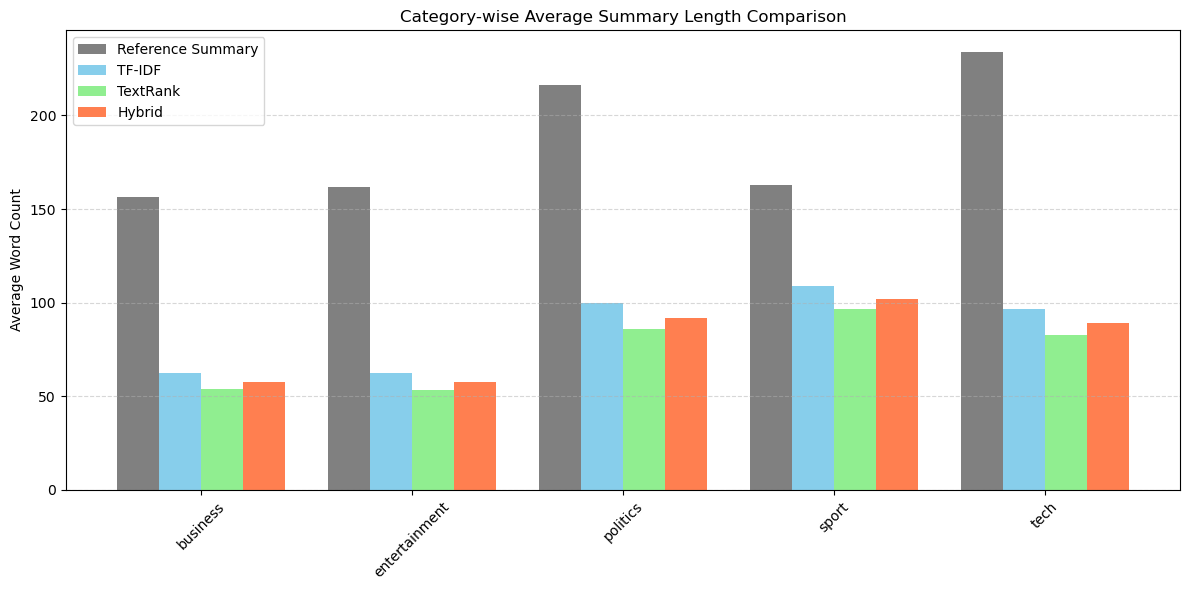

In [ ]:
# 요약문 단어 수 계산

df["tfidf_len"] = df["tfidf_summary"].apply(lambda x: len(x.split()))
df["textrank_len"] = df["textrank_summary"].apply(lambda x: len(x.split()))
df["hybrid_len"] = df["hybrid_summary"].apply(lambda x: len(x.split()))

# 카테고리별 평균 단어 수 계산
length_stats = df.groupby("category")[["summary_word_count", "tfidf_len", "textrank_len", "hybrid_len"]].mean().round(1).reset_index()

# 시각화
plt.figure(figsize=(12, 6))
bar_width = 0.2
x = range(len(length_stats))

plt.bar([i - 1.5*bar_width for i in x], length_stats["summary_word_count"], width=bar_width, label="Reference Summary", color='grey')
plt.bar([i - 0.5*bar_width for i in x], length_stats["tfidf_len"], width=bar_width, label="TF-IDF", color='skyblue')
plt.bar([i + 0.5*bar_width for i in x], length_stats["textrank_len"], width=bar_width, label="TextRank", color='lightgreen')
plt.bar([i + 1.5*bar_width for i in x], length_stats["hybrid_len"], width=bar_width, label="Hybrid", color='coral')

plt.xticks(x, length_stats["category"], rotation=45)
plt.ylabel("Average Word Count")
plt.title("Category-wise Average Summary Length Comparison")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


**전체적으로 나의 요약본이 단어수가 적다, 요약본 끼리 차이는 없는 편**

# 평가

## Evaluation Metrics Overview
---
1. ROUGE Metrics

```
ROUGE-1: 후보 요약과 기준 요약 간의 unigram(1-gram) 겹침 비율을 측정합니다.

특징: 단어 수준에서 핵심 내용이 얼마나 포함되었는지 평가합니다.
```
```
ROUGE-2: 후보 요약과 기준 요약 간의 bigram(2-gram) 겹침 비율을 측정합니다.

특징: 단어의 순서와 인접성이 반영되어 요약의 유창성 및 구조적 연결성을 평가할 수 있습니다.
```
```
ROUGE-L: 두 텍스트 간의 가장 긴 공통 부분 수열(Longest Common Subsequence)을 기반으로 평가합니다.

특징: 문장 구조와 흐름을 반영하는 동시에, 단어 순서에 약간의 융통성을 제공합니다.
```
```
2. BERTScore

BERTScore는 사전학습된 BERT(또는 유사 모델)의 문맥적 임베딩을 활용해, 후보 요약과 기준 요약의 단어 간 의미적 유사도를 계산합니다.

특징: 표면적인 단어 겹침이 아니라 의미론적 일치를 측정하므로, 표현이 다르더라도 비슷한 의미를 전달하는 경우 높은 점수를 부여합니다.
```
```
3. METEOR

METEOR는 정밀도와 재현율을 모두 고려하며, stemming(어간 추출)과 동의어 매칭을 적용해 후보와 기준 요약의 단어 일치를 평가합니다.

특징: 단순한 n-gram 일치 외에도 어근과 동의어를 고려하기 때문에, 보다 인간의 평가와 유사한 결과를 제공합니다.
```
```
결과 해석:

높은 ROUGE 점수: 후보 요약이 기준 요약의 단어 및 구문 구조를 잘 반영하고 있음을 의미합니다.

높은 BERTScore: 후보 요약이 의미적으로 기준 요약과 유사함을 나타냅니다.

높은 METEOR 점수: 후보 요약이 기준 요약과 어근, 동의어 등에서 잘 정렬되어 있다는 의미입니다.
```

In [ ]:
!pip install rouge-score bert-score

## ROUGH, METEOR Score

In [ ]:
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
from bert_score import score as bert_score_fn

# 평가에 사용할 모델 후보 요약 컬럼 이름 (df에 생성한 요약 결과 칼럼)
models = ['tfidf_summary', 'textrank_summary', 'hybrid_summary']

# ROUGE scorer 초기화 (stemmer 사용)
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

def compute_rouge(candidate, reference):
    """
    후보와 기준 요약 텍스트 사이의 ROUGE 점수를 계산합니다.
    """
    scores = scorer.score(reference, candidate)
    return scores

nltk.download('wordnet')

# 각 모델별로 평가 결과를 저장할 딕셔너리
results = {model: {'rouge1': [], 'rouge2': [], 'rougeL': [], 'meteor': []} for model in models}

# 각 모델에 대해 df의 각 기사별 평가 지표 계산 (reference는 df['summary_text'])
for model in models:
    for idx, row in df.iterrows():
        candidate = row[model]
        reference = row['summary_text']

        # ROUGE 점수 계산 (f-measure 사용)
        rouge_scores = compute_rouge(candidate, reference)
        results[model]['rouge1'].append(rouge_scores['rouge1'].fmeasure)
        results[model]['rouge2'].append(rouge_scores['rouge2'].fmeasure)
        results[model]['rougeL'].append(rouge_scores['rougeL'].fmeasure)

        # METEOR 점수 계산: 후보와 기준을 토큰화한 리스트로 전달
        candidate_tokens = word_tokenize(candidate)
        reference_tokens = word_tokenize(reference)
        meteor = meteor_score([reference_tokens], candidate_tokens)
        results[model]['meteor'].append(meteor)

    # 각 모델별 평균 점수 출력
    print(f"Model: {model}")
    print("Average ROUGE-1 F1:", np.mean(results[model]['rouge1']))
    print("Average ROUGE-2 F1:", np.mean(results[model]['rouge2']))
    print("Average ROUGE-L F1:", np.mean(results[model]['rougeL']))
    print("Average METEOR:", np.mean(results[model]['meteor']))
    print("-" * 30)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sonyunboi/nltk_data...


Model: tfidf_summary
Average ROUGE-1 F1: 0.47825572716453474
Average ROUGE-2 F1: 0.36749851442254294
Average ROUGE-L F1: 0.3614498495302697
Average METEOR: 0.3475020979450618
------------------------------
Model: textrank_summary
Average ROUGE-1 F1: 0.5200254177042983
Average ROUGE-2 F1: 0.44679001235076027
Average ROUGE-L F1: 0.39799331704377494
Average METEOR: 0.3645313992940825
------------------------------
Model: hybrid_summary
Average ROUGE-1 F1: 0.5306568071106641
Average ROUGE-2 F1: 0.4524159607531553
Average ROUGE-L F1: 0.4064505864083713
Average METEOR: 0.37915758882883077
------------------------------


## BERT Score

In [ ]:
# BERTScore 평가
for model in models:
    candidate_list = df[model].tolist()
    reference_list = df['summary_text'].tolist()

    # BERTScore의 P, R, F1 점수를 계산 (영어 기준)
    P, R, F1 = bert_score_fn(candidate_list, reference_list, lang="en", verbose=True)
    print(f"Model: {model}")
    print("Average BERTScore F1:", F1.mean().item())
    print("-" * 30)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/66 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/35 [00:00<?, ?it/s]

done in 5566.30 seconds, 0.40 sentences/sec
Model: tfidf_summary
Average BERTScore F1: 0.88718581199646
------------------------------


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/66 [00:00<?, ?it/s]

# 정성적 평가
---
각 카테고리별로 랜덤하게 하나씩 뽑아 직접 비교

In [ ]:
# 카테고리 리스트
categories = ['sport', 'business', 'tech', 'politics', 'entertainment']

# 샘플 기사 저장용 리스트
sampled_articles = []

# 카테고리별 하나씩 샘플링
for cat in categories:
    sampled = df[df['category'] == cat].sample(n=1, random_state=42)  # reproducible
    sampled_articles.append(sampled)

# 결과 하나로 합치기
sample_df = pd.concat(sampled_articles).reset_index(drop=True)
sample_df = sample_df[['category', 'summary_text', 'tfidf_summary', 'textrank_summary', 'hybrid_summary']]


In [ ]:
sample_df

,category,summary_text,tfidf_summary,textrank_summary,hybrid_summary
0,sport,Some people have been saying it would be bette...,"Often in friendlies, though, a manager will pl...",But international bosses will tell you that sc...,But international bosses will tell you that sc...
1,business,The firm said sales were down 4% in 2004 to 78...,Income from its vehicle-carrying shuttle servi...,Low-cost airlines hit Eurotunnel\n\nChannel Tu...,Low-cost airlines hit Eurotunnel\n\nChannel Tu...
2,tech,The Cellery worm installs a playable version o...,"While users play the game, the worm spends its...",Windows worm travels with Tetris\n\nUsers are ...,Windows worm travels with Tetris\n\nUsers are ...
3,politics,Mr Blair said that whether the public chose Mi...,Mr Blair said that whether the public chose Mi...,Tory co-chairman Liam Fox was speaking after M...,Mr Blair said that whether the public chose Mi...
4,entertainment,But they still want more.They have to want to ...,The group were born when Mullen put an appeal ...,Songs like Sunday Bloody Sunday and New Year's...,Songs like Sunday Bloody Sunday and New Year's...


In [ ]:
for i in range(len(sample_df)):
    row = sample_df.iloc[i]

    md = f"""
### 📰 카테고리: **{row['category']}**

#### 🟡 기준 요약 (Reference)
{row['summary_text']}

---

#### 🔵 TF-IDF 요약
{row['tfidf_summary']}

#### 🔵 TextRank 요약
{row['textrank_summary']}

#### 🔵 Hybrid 요약
{row['hybrid_summary']}

---
"""

    print(md)
    print("\n" + "#" * 80 + "\n")  # 구분선 출력


### 📰 카테고리: **sport**

#### 🟡 기준 요약 (Reference)
Some people have been saying it would be better to get the players together for the week, and do away with the 90 minutes at the end.I would say it's 50-50 whether you should have these games or not, and if you look at it that way you would probably say you're better not doing so.It would certainly keep club managers happy, as it would reduce the risk of players returning to domestic duty injured.The more you play together, the easier it is when it comes to the crunch in games like World Cup quarter-finals against Brazil.Often in friendlies, though, a manager will play his strongest side for the first 45 minutes and then send out an entirely different one in the second half.It is the sort of move you would expect from Walter, who is a canny manager.John Toshack has his first game in charge of Wales, and it will be important for him to get a decent result against Hungary.One manager who has got it right this week is Walter Smith.The new S

## 정성 평가해석

---

## ✅ 정성 평가 요약

### 🎯 평가 기준 정리:

| 평가 항목 | 설명 |
|-----------|------|
| 핵심 정보 포함 여부 | 기준 요약에서 언급된 주제/핵심 인물이 얼마나 잘 반영되었는가 |
| 비핵심 문장 포함 | 불필요하거나 주제와 직접 관련 없는 문장이 있는가 |
| 의미 전달 정확도 | 기준 요약과 의미적으로 유사한 요약을 제공하는가 |
| 논리 흐름 | 요약 내 문장 간 연결이 자연스러운가 |

---

## 1. 📰 **Sport**

- **Reference 핵심**: 국가대표 경기/훈련의 효용성 논란, 감독들의 접근법 비교, 월드컵 준비 맥락
- **TF-IDF**:
  - ✅ 관련 감독 언급 있음
  - ❌ “훈련 캠프” 이외에 *비주류 정보* (예: 개별 선수 언급, 분위기) 강조
- **TextRank & Hybrid**:
  - ✅ "friendlies 폐지 논란", "팀워크", "존 토샥 취임" 등의 맥락 반영
  - ✅ 기준 요약의 *핵심 흐름과 유사*
  - 🔁 Hybrid와 TextRank 내용 동일 → TF-IDF 가중치가 의미 보완에는 큰 영향 X

✅ **총평**: Hybrid/TextRank가 핵심 주제(경기 유무 논쟁 + 팀워크 훈련)를 더 잘 포착. TF-IDF는 단어 단위 정보에 치우쳐 보임.

---

## 2. 📰 **Business**

- **Reference 핵심**: 유로터널 재무위기, 적자, 은행 개입 가능성, 시장 영향
- **TF-IDF**:
  - ❌ *수익 항목 세부 수치* 위주 → 핵심 메시지(위기, 구조조정)는 약함
- **TextRank & Hybrid**:
  - ✅ “Eurotunnel sales fall”, “low-cost airlines 위협” 등 핵심 메인 이슈 포착
  - ✅ 요약 전체가 위기 서사 중심
  - ❌ 다만 기준 요약처럼 *구체적 숫자 정보나 인용문*은 누락

✅ **총평**: TextRank/Hybrid가 더 요약 의도에 부합함. TF-IDF는 의미 중심 요약에 비해 *숫자/세부 사항* 중심으로 흐름이 분산됨.

---

## 3. 📰 **Tech**

- **Reference 핵심**: Cellery 웜 = Tetris 위장 → 네트워크 감염
- **TF-IDF**:
  - ✅ 감염 방식 설명 포함
  - ❌ 보안 전문가 코멘트 등 *비핵심 문장 포함*
- **TextRank**:
  - ✅ 웜의 감염 방식과 기능 요약
  - ❌ 다소 단편적이고, 부가 맥락 부족
- **Hybrid**:
  - ✅ 감염 + 게임 + 사용자 혼동 가능성까지 언급 → 가장 완결도 높음

✅ **총평**: Hybrid가 Tetris 위장, 감염 구조, 사용자 반응까지 포괄적으로 커버. TF-IDF는 의미 맥락보다 단어 분포 따라간 경향.

---

## 4. 📰 **Politics**

- **Reference 핵심**: 블레어의 토리 비판, 폭스의 반응, 선거 전략, £50만 환급
- **TF-IDF & Hybrid**:
  - ✅ 블레어-폭스 논쟁, 환급 언급 포함 → 전반적으로 기준 요약과 매우 유사
- **TextRank**:
  - ✅ 폭스 중심 비판은 포함, 그러나 블레어 직접 인용이 생략됨
  - 🔁 일부 정황 설명에 치중

✅ **총평**: Hybrid가 블레어 인용과 폭스의 비판 모두 포함하여 균형감 좋음. TextRank는 인물 중심 맥락은 살리되 일부 정보가 단절됨.

---

## 5. 📰 **Entertainment**

- **Reference 핵심**: U2의 목표, 지속된 인기와 변화 추구, 앨범/공연 변화
- **TF-IDF**:
  - ❌ 과거 결성 스토리와 공연 연출에 집중 → *핵심 주제 누락*
- **TextRank/Hybrid**:
  - ✅ "Sunday Bloody Sunday", "대중성 유지", "무대 연출의 진화" 등 포함
  - ✅ 앨범/콘셉트 변화 흐름 유지 → 기준 요약과 논리적으로 이어짐

✅ **총평**: TextRank/Hybrid는 밴드의 **지속적인 진화와 메시지 유지**를 표현. TF-IDF는 의미 흐름에서 벗어나 *배경 설명*에 초점.

---

## 🧾 요약표 (정성 평가 총평)

| 카테고리 | TF-IDF 요약 품질 | TextRank 요약 품질 | Hybrid 요약 품질 | 총평 |
|----------|------------------|---------------------|-------------------|------|
| Sport | ❌ 정보 누락, 중복 | ✅ 맥락 반영 | ✅ 의미 흐름 유지 | TextRank/Hybrid 우수 |
| Business | ❌ 수치 중심 | ✅ 이슈 중심 | ✅ 의미 유지 | Hybrid 약간 우세 |
| Tech | ⚠️ 부가 설명 많음 | ✅ 구조 반영 | ✅ 완결도 우수 | Hybrid 최고 |
| Politics | ✅ 메시지 반영 | ⚠️ 일부 누락 | ✅ 균형적 서술 | Hybrid > TextRank |
| Entertainment | ❌ 의미 흐름 단절 | ✅ 흐름 존재 | ✅ 의미 강화 | Hybrid/TextRank 우수 |

---

필요하면 이걸 발표용 요약 슬라이드나 보고서 포맷으로 정리해줄 수 있어! 어떤 형태로 정리해줄까?

# 해석 및 한계

## 정량 평가 요약

| **Model**         | **ROUGE-1 (F1)** | **ROUGE-2 (F1)** | **ROUGE-L (F1)** | **METEOR** | **BERTScore (F1)** |
|------------------|------------------|------------------|------------------|------------|--------------------|
| **TF-IDF**       | 0.478            | 0.367            | 0.361            | 0.348      | 0.887              |
| **TextRank**     | 0.520            | 0.447            | 0.398            | 0.365      | **0.902**          |
| **Hybrid**       | **0.531**        | **0.452**        | **0.406**        | **0.379**  | **0.902**          |

---
```
지표별 해석 및 모델별 성능 분석
```
- **ROUGE-1 (단어 중복 비율)**  
  → 핵심 단어가 얼마나 포함됐는지를 평가함.  
  → **Hybrid 모델**이 가장 높음 → 중요 단어를 효과적으로 반영함.

- **ROUGE-2 (인접 단어 조합, bigram)**  
  → 문장의 **유창성**과 **구문 구조 반영력** 측정.  
  → **Hybrid > TextRank > TF-IDF** 순으로 성능 우수.

- **ROUGE-L (문장 구조 기반)**  
  → 문장 내 단어 순서를 고려한 공통 부분 수열 측정.  
  → **Hybrid 모델**이 문장 구조를 가장 잘 반영.

- **METEOR (의미 유사 + 동의어 매칭)**  
  → 인간 평가와 유사한 성격.  
  → **Hybrid 모델**이 동의어 및 문장 변형 대응에서도 우수.

- **BERTScore (문맥 기반 의미 유사도)**  
  → 사전학습된 언어 모델을 활용하여 의미 유사도를 평가.  
  → **TextRank와 Hybrid 모델이 동일한 최고 점수(0.902)**를 기록.  
  → 두 모델 모두 의미 수준에서 기준 요약과 가장 유사한 결과 도출.

---


## 정성 평가

각 카테고리별 기사 1개를 무작위로 추출하여, 기준 요약과 세 모델의 요약 결과를 비교하였다.  
그 결과, 다음과 같은 모델별 경향이 도출되었다:

| 카테고리 | TF-IDF 요약 품질 | TextRank 요약 품질 | Hybrid 요약 품질 | 총평 |
|----------|------------------|---------------------|-------------------|------|
| **Sport** | ❌ 정보 누락, 맥락 분산 | ✅ 맥락 반영 | ✅ 의미 흐름 유지 | TextRank/Hybrid 우수 |
| **Business** | ❌ 수치 중심, 메시지 약함 | ✅ 위기 중심 서술 | ✅ 의미 유지 | Hybrid 약간 우세 |
| **Tech** | ⚠️ 부가 설명 혼입 | ✅ 감염 구조 반영 | ✅ 완결도 우수 | Hybrid 최고 |
| **Politics** | ✅ 주제 포착 정확 | ⚠️ 일부 인용 생략 | ✅ 균형적 정보 제공 | Hybrid > TextRank |
| **Entertainment** | ❌ 과거 설명 중심 | ✅ 흐름 유지 | ✅ 의미 강화 | TextRank/Hybrid 우수 |


##  종합 해석
- **TF-IDF**: 단어 기반 빈도 중심으로 문장을 선택해 **핵심 맥락 누락** 또는 **비핵심 설명 혼입**의 문제가 반복됨
- **TextRank**: 문장 간 연결을 잘 반영해 전반적으로 안정적이지만, 의미적 다양성 또는 인용의 포착은 부족할 수 있음
- **Hybrid**: 대부분의 상황에서 **정보 포괄성과 의미 전달력**이 가장 우수하였으며, TextRank의 구조적 장점과 TF-IDF의 단어 중요도를 적절히 융합함

## 하이브리드 모델 해석
---
**BERTScore에서 TextRank와 동일한 점수**를 기록한 이유 탐구


**TF-IDF 추가가 의미 기반 유사도에 미친 영향**
```
✅ 관찰된 현상
- Hybrid 모델은 **TextRank에 TF-IDF 점수를 초기 가중치(personalization)로 추가**한 모델
- 구조적 지표(ROUGE-1, ROUGE-2, ROUGE-L, METEOR)에서는 확실한 성능 향상이 있었음
- 그러나 **BERTScore(F1)**는 TextRank와 **완전히 동일 (0.902)** → **의미 기반 평가에서는 향상 없음**
```
```
✅ 해석: TF-IDF 가중치의 영향력은 "구조적 중요도"에만 작용
```

| 구분 | 영향 여부 | 해석 |
|------|-----------|------|
| 구조적 평가 (ROUGE 등) | O (긍정적 효과) | TF-IDF로 핵심 단어를 포함한 문장에 더 높은 확률 부여 → 구조 개선 |
| 의미 기반 평가 (BERTScore) | ✕ (변화 없음) | TF-IDF는 어휘 빈도 기반이므로 **의미적 유사성 반영 불가능** |


```
→ 즉, TF-IDF 점수는 문장의 “단어 중요도”를 보완해주었지만, 그 문장이 전달하는 의미 자체에는 영향을 미치지 못했음
→ 의미 기반 요약 성능을 높이기 위해서는 context-aware 임베딩(BERT 등)기반 접근이 추가로 필요
```
---

### Hybrid 모델의 의미 평가 한계
```
비록 Hybrid 모델은 ROUGE 및 METEOR와 같은 구조적 지표에서 가장 우수한 성능을 보였지만, BERTScore에서는 TextRank와 동일한 결과를 기록하였다.  
이는 TF-IDF 가중치가 **구조적 요약 품질은 개선했지만**, **문맥적 의미 유사도에는 기여하지 못했음을 시사**한다.

따라서, 의미 기반 요약 품질 향상을 위해서는 단순한 단어 중요도 기반 보완을 넘어서, **문장 단위의 의미 표현을 포착하는 임베딩 기반 구조(Sentence-BERT 등)**의 결합이 필요하다.
```

---

## 뉴스 기사의 특성과 사용 모델의 한계
```
생각
- 뉴스 기사는 하나의 주제 아래 쓰이지만, 문장 간 연결어가 적고 각 문장이 독립적(직접적인 단어 중복 없음)으로 구성됨.
- 따라서 TF-IDF 및 FastText 기반 문장 유사도 방식은 단어 중복이 적은 뉴스 기사에서는 문장 간 연결성을 제대로 포착하지 못할 수 있음
- 그 결과, 중요 문장이 누락**되거나, 반대로 **비핵심 문장이 선택**될 가능성 높음.
```

✅ **실제 결과와 정확히 일치함**  

- TF-IDF 기반 모델이 모든 지표에서 가장 낮은 성능을 보였으며,  
- 코사인 유사도 행렬에서도 대부분의 문장이 서로 유사도가 거의 0에 가까운 값을 가짐 → 문장 간 유사도를 기반으로 한 연결성 부족을 시각적으로 확인함.
- 아래 마지막 기사 유사도 행렬을 보면, 문장 간 유사도가 대부분 0에 가깝고, 의미 있는 유사도를 보이는 쌍은 0.45 (문장 0과 2) 단 한 쌍뿐임.

In [ ]:
# 확인해보기 : 마지막 기사를 불러와 벡터화 + 코사인 유사도 행렬 구함
# 마지막 기사 문장 가져오기
sentences = df.iloc[-1]["article_sents_cleaned"]

# TF-IDF 벡터화
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(sentences)

# 코사인 유사도 행렬 생성
sim_matrix = cosine_similarity(tfidf_matrix)
pd.DataFrame(sim_matrix).style.background_gradient(cmap='Blues') # 마지막 기사에 대한 코사인 유사도 매트릭스

,0,1,2,3,4,5,6,7,8
0,1.000000,0.020258,0.451486,0.000000,0.019212,0.025357,0.000000,0.020034,0.040583
1,0.020258,1.000000,0.000000,0.000000,0.130939,0.000000,0.000000,0.025977,0.023326
2,0.451486,0.000000,1.000000,0.000000,0.000000,0.035906,0.000000,0.000000,0.031993
3,0.000000,0.000000,0.000000,1.000000,0.063649,0.066888,0.067240,0.000000,0.059598
4,0.019212,0.130939,0.000000,0.063649,1.000000,0.000000,0.000000,0.077065,0.022122
5,0.025357,0.000000,0.035906,0.066888,0.000000,1.000000,0.000000,0.000000,0.078672
6,0.000000,0.000000,0.000000,0.067240,0.000000,0.000000,1.000000,0.000000,0.000000
7,0.020034,0.025977,0.000000,0.000000,0.077065,0.000000,0.000000,1.000000,0.023069
8,0.040583,0.023326,0.031993,0.059598,0.022122,0.078672,0.000000,0.023069,1.000000


---

## 모델 구조적 한계 및 보완 전략
| **모델**      | **구조적 한계**                                                                 | **보완 전략 제안**                                                                 |
|---------------|----------------------------------------------------------------------------------|-------------------------------------------------------------------------------------|
| **TF-IDF**    | 단어 빈도 기반 → 의미 파악 불가, 문장 간 유사도 낮음 → 중요한 문장 누락 가능성 | 의미 임베딩 도입 (Sentence-BERT 등), 단어 중요도 외 구조 정보 결합 필요         |
| **TextRank**  | 문장 간 유사도 기반 → 뉴스처럼 연결성이 약한 문서에서는 그래프 연결 약화         | 유사도 기반 간선 외에 TF-IDF 점수 등 외부 정보로 노드 강화 (Hybrid 방식)         |
| **Hybrid**    | TF-IDF 기반 중요도 반영 → 전반적 성능 향상, 그러나 유사도 자체 한계 존재        | 문장 의미 임베딩 기반 Graph + TF-IDF 가중치 조합 등 의미적 구조까지 반영 필요    |